In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from seispy.station.stationdata import SeismometerArray
import pymultinest
from seispy.station import homestake, spiral
from scipy.linalg import pinv2,svd
from scipy.sparse.linalg import lsqr
import astropy.units as u
import numpy as np
import seispy.plotter.plot as hplot
import healpy as hp
import NX01_AnisCoefficients as anis
import AnisCoefficients_pix as pixAnis

/home/meyers/opt/seispy/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# parameters
st = 1113243653
et = st + 5
stationlist = ['A4850', 'B4850', 'A2000', 'D2000','800','RRDG']

# Simulate Data

Simulate data and set up some functions for subtracting data from seismometer arrays.

The function "add_p_wave" takes our seismometers and injects a p-wave at the proper amplitude in each detector. In principle, this is where the physics is, and this is where we can add complexity if we want to do time-domain waveform stuff like this. The velocity here is variable.

In [9]:
#stations = homestake(stationlist)
stations = spiral(3)
EventData = SeismometerArray.initialize_all_good(stations, 10, chans_type='fast_chans', Fs=4)
# add a p-wave coming in with ampltiude 1e-4 m/s at 30 degrees east of north
# and 30 degrees south of horizontal. We want 1000s of data and a velocity of 5700.
EventData.add_p_wave(1e-4, np.radians(120), np.radians(120), 1, 10, c=5700, Fs=4)

def subtraction(arr1, arr2):
    arr1stations = arr1.keys()
    arr1chans = arr1[arr1stations[0]].keys()
    nchans = len(arr1stations) * len(arr1chans)
    nsamps = arr1[arr1stations[0]][arr1chans[0]].size
    resids = np.zeros((nchans,nsamps))
    ct = 0
    for key in arr1.keys():
        for key2 in arr1[key].keys():
            resids[ct,:] = arr1[key][key2].value - arr2[key][key2].value
            ct +=1
    return resids
pat = subtraction(EventData, EventData)
# get covariance matrix
cov = np.diag((np.ones(pat.shape) * 1e-12).flatten())
def gen_and_subtract(arr1, stations, v, theta, phi, amp):
    arr2 = SeismometerArray.initialize_all_good(stations, 10, chans_type='fast_chans', Fs=4)
    arr2.add_p_wave(1e-4, np.radians(120), np.radians(120), 1, 10, c=5700, Fs=4)
    return subtraction(arr1,arr2)
#%timeit gen_and_subtract(EventData, stations, 5700, 120, 120, 1e-4)
%timeit gen_and_subtract(EventData, stations, 5700, 120, 120, 1e-4)

100 loops, best of 3: 12.5 ms per loop


# Plot Array

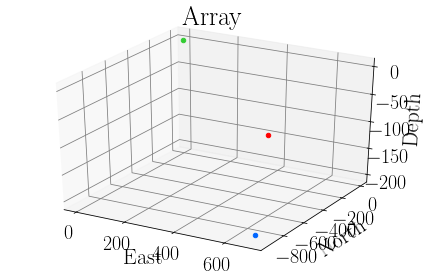

In [4]:
# amplitude = 1e-4
# strs = ['p','r']
# # set up array
# stations = homestake(stationlist)
plot = stations.plot()
plt.title('Array')
plt.tight_layout()
plt.show()
# # get data
# EventData = SeismometerArray.fetch_data(st, et,
#         framedir='/archive/frames/homestake/', chans_type='fast_chans', stations=stationlist)
# # get pre-event data to use for covariance matrix
# PreEventData = SeismometerArray.fetch_data(st-1000, st-100,
#         framedir='/archive/frames/homestake/', chans_type='fast_chans', stations=stationlist)
# print EventData.keys()

In [5]:
# do matrix inversion
Y = np.mean(Ys, 1)
def logLike(cube, ndim, nparams):
    # get parameters from cube
    v, phi, theta, A = cube[0], cube[1], cube[2], cube[3]
    # get gamma
    gamma, phis, thetas, shapes = EventData.get_gamma_matrix_healpy('p',
        stations, 1, v, nside=4)
    # get test map
    test_map = np.zeros(phis.size)
    idx = hp.pixelfunc.ang2pix(4, theta, phi)
    test_map[idx] = A**2
    test_map[idx] = 1
    Plm = pixAnis.clmFromMap(inj_map, 3) * A**2 * 100
    test_map = pixAnis.mapFromClm(Plm, 4)
    dat = (Y - np.dot(gamma.T, test_map))
    return -0.5 * np.dot(np.dot(dat.T.conj(), N_inv), dat)
def prior(cube, ndim, nparams):
    # velocity uniform 2000 -> 10000
    cube[0] = 5500 + 500*cube[0]
    # phi -> 0, 2pi
    cube[1] = np.radians(110) + np.radians(20) * cube[1]
    # theta -> 0, pi
    cube[2] = np.radians(110) + np.radians(20) * cube[2]
    # amplitude -> LogUniform(1e-5, 1e-3)
    cube[3] = 10**(-5 + cube[3]*2)
    return cube
print logLike(prior([0.5,0.5,0.5,0.5],4,4),4,4)
%timeit logLike(prior([0.5,0.5,0.5,0.5],4,4),4,4)

NameError: name 'Ys' is not defined

In [ ]:
pymultinest.run(logLike, prior, 4, n_live_points=400, verbose=True)